<a href="https://colab.research.google.com/github/ssoyyoungg/first-repository/blob/master/human_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models

In [ ]:
!pip install tensorflow==2.9.1
!pip install keras==2.9.0

In [ ]:
import os
import urllib
import cv2
import numpy as np
import segmentation_models as sm
from matplotlib import pyplot as plt

Segmentation Models: using `keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


(1440, 1080, 3)


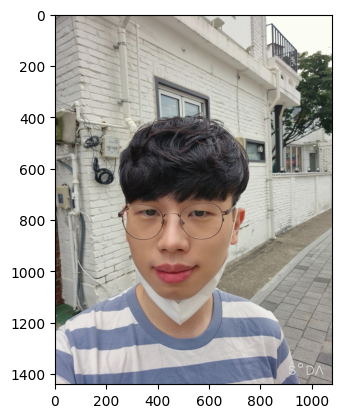

In [ ]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
image_path = '/content/drive/MyDrive/Colab Notebooks/human_segmentation/images/my_image.jpg'
img_orig = cv2.imread(image_path)

print(img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = '/content/drive/MyDrive/Colab Notebooks/human_segmentation/models'

# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model = sm.Unet('resnet34', input_shape=(None, None, 3), classes=21, activation='softmax')

85521592/85521592 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 이미지 로드 및 크기 조정
image = load_img(image_path, target_size=(512, 512))  # 원하는 입력 크기로 조정
image = img_to_array(image)

# 이미지 전처리 (Unet 모델의 ResNet34 백본에 맞는 전처리 함수 사용)
preprocess_input = sm.get_preprocessing('resnet34')
image = preprocess_input(image)

# 모델 입력을 위한 차원 확장 (배치 차원 추가)
image = np.expand_dims(image, axis=0)

In [ ]:
# 모델 예측
pred_mask = model.predict(image)

# 예측 결과 후처리 (argmax를 사용해 클래스 차원을 제거)
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = pred_mask[0]  # 첫 번째 배치의 결과를 사용


1/1 [==============================] - 0s 276ms/step


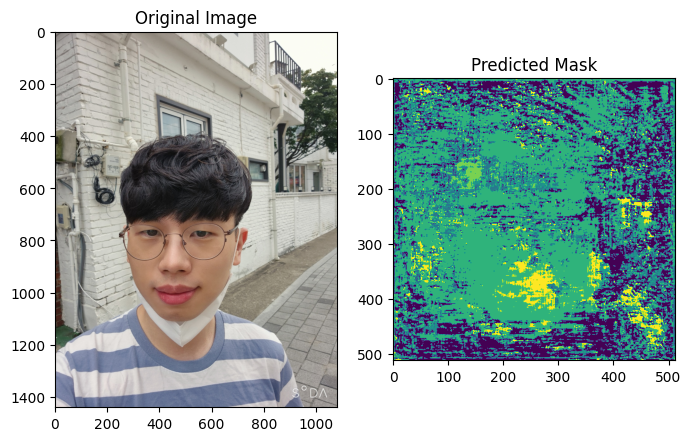

In [ ]:
# 예측된 마스크 시각화
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(load_img(image_path))  # 원본 이미지

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(pred_mask)  # 예측된 마스크

plt.show()


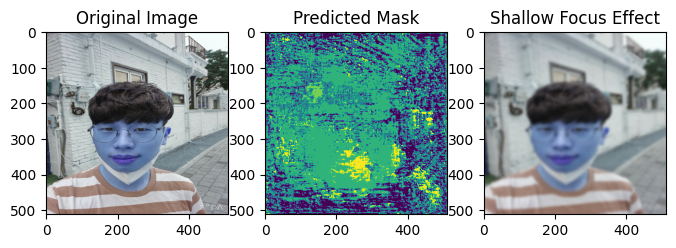

In [ ]:
# 원본 이미지 로드 (전처리 없이)
original_image = img_to_array(load_img(image_path, target_size=(512, 512)))

# 블러 효과 적용
blurred_image = cv2.GaussianBlur(original_image, (21, 21), 0)

# 마스크 적용: 배경은 블러 처리하고, 전경은 원본 이미지 유지
masked_image = np.where(pred_mask[..., np.newaxis] == 1, original_image, blurred_image)

# 결과 시각화
plt.figure(figsize=(8, 8))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image.astype('uint8'), cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(pred_mask)

plt.subplot(1, 3, 3)
plt.title("Shallow Focus Effect")
plt.imshow(cv2.cvtColor(masked_image.astype('uint8'), cv2.COLOR_BGR2RGB))

plt.show()


# 성능이 좋지 않다 생각하여 새로 만들어 보자

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


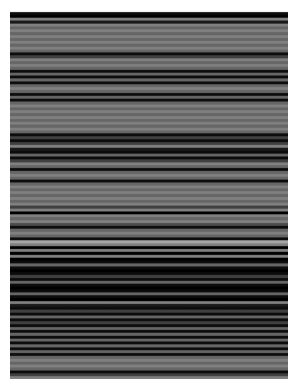

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix

# 1. DeepLabV3+ 모델 로드
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

# Upsampling path
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

# Define the DeepLabV3+ Model
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2, padding='same')  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

OUTPUT_CLASSES = 21  # pascal voc의 클래스 개수
model = unet_model(OUTPUT_CLASSES)

# Load your image
img_path = '/content/drive/MyDrive/Colab Notebooks/human_segmentation/images/my_image.jpg'
img_orig = cv2.imread(img_path)
input_img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
input_img = cv2.resize(input_img, (128, 128))

# Predict
pred_mask = model.predict(np.expand_dims(input_img, axis=0))

# Convert predicted mask to class labels
pred_mask = tf.argmax(pred_mask, axis=-1)
pred_mask = tf.squeeze(pred_mask)

# Map the class labels to colors
def create_mask(pred_mask):
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

# Resize the mask back to the original image size
pred_mask_resized = cv2.resize(create_mask(pred_mask).numpy(), (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_NEAREST)

plt.imshow(pred_mask_resized, cmap='gray')
plt.axis('off')
plt.show()


# 무언가 오류가 있다고 판단 새로운 코드 작성

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
from matplotlib import pyplot as plt
import tensorflow as tf

In [ ]:
img_path = '/content/drive/MyDrive/Colab Notebooks/human_segmentation/images/my_image.jpg'
img_orig = cv2.imread(img_path)
print (img_orig.shape)

(1440, 1080, 3)


In [ ]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다.
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input

    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [ ]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/content/drive/MyDrive/Colab Notebooks/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /content/drive/MyDrive/Colab Notebooks/human_segmentation/models
model loaded successfully!


In [ ]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력합니다.
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1440, 1080, 3) (513, 384, 3) 15


In [ ]:
# 제공하는 라벨 종류는 아래와 같습니다.
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

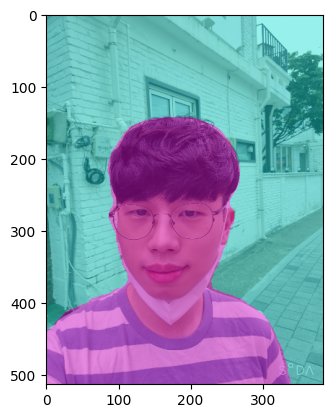

In [ ]:
# 사진 중에서 사람의 라벨, 즉 15를 가진 영역만 검출해 봅시다.
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_COOL)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

원본 이미지의 크기: (1080, 1440)
변형 마스크의 크기: (513, 384)


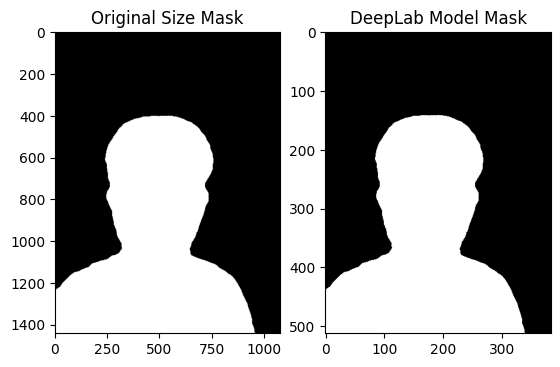

In [ ]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

print(f'원본 이미지의 크기: {img_orig.shape[:2][::-1]}\n변형 마스크의 크기: {img_mask.shape}')
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

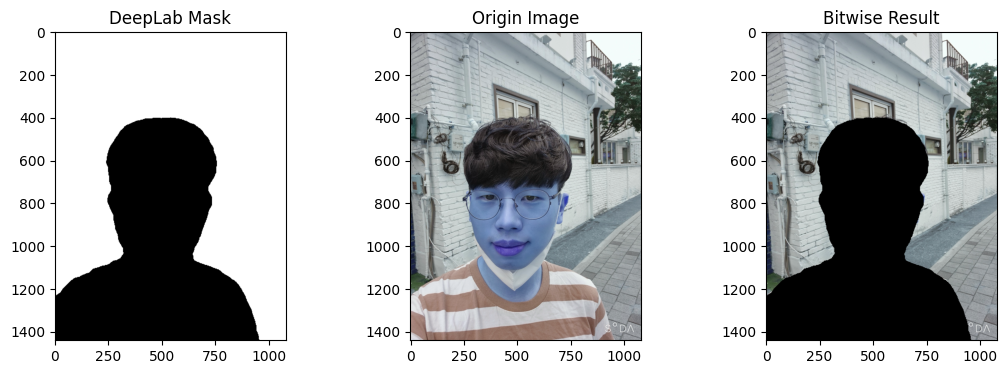

In [ ]:
#세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

fig = plt.figure(figsize=(13, 4))

ax = plt.subplot(1,3,1)
plt.imshow(img_bg_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Mask')

ax = plt.subplot(1,3,2)
plt.imshow(img_orig, cmap=plt.cm.binary_r)
ax.set_title('Origin Image')

ax = plt.subplot(1,3,3)
plt.imshow(img_bg, cmap=plt.cm.binary_r)
ax.set_title('Bitwise Result')

plt.show()

Text(0.5, 1.0, 'Blur Processing')

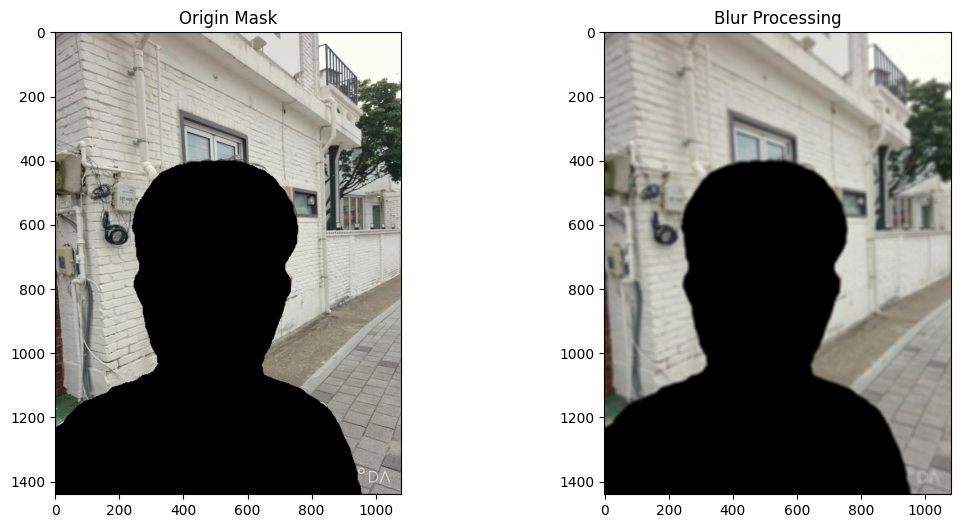

In [ ]:
# 이 이미지를 블러(blur)하면 배경이 흐리게 처리된 영상을 얻을 수 있습니다.
img_bg_blur = cv2.blur(img_bg, (12,12))

fig = plt.figure(figsize=(13, 6))

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Origin Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Blur Processing')

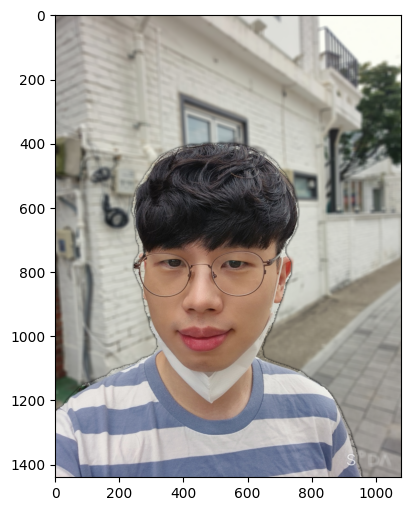

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
fig = plt.figure(figsize=(16, 6))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 다시 합성한 사진의 선이 어색해 조정

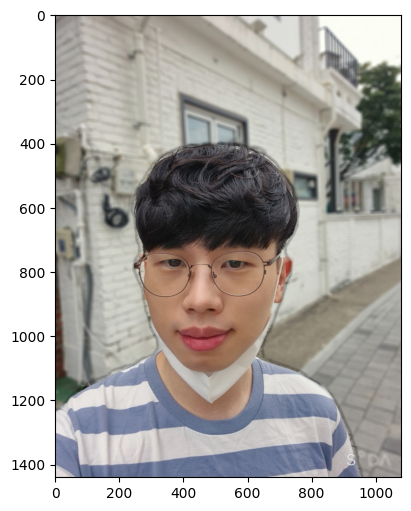

In [ ]:
# 가우시안 블러를 이용해 마스크 경계 부드럽게 처리
img_mask_up = cv2.GaussianBlur(img_mask_up, (15, 15), 0)

# Morphological Operation 적용 (팽창 후 침식)
kernel = np.ones((5,5), np.uint8)
img_mask_up = cv2.dilate(img_mask_up, kernel, iterations=1)
img_mask_up = cv2.erode(img_mask_up, kernel, iterations=1)

# Feathering 적용
img_mask_blur = cv2.GaussianBlur(img_mask_up, (21, 21), 0)
# alpha_mask를 3D 배열로 확장
alpha_mask = np.stack([alpha_mask] * 3, axis=-1)  # (1440, 1080) -> (1440, 1080, 3)

# 이미지 합성
img_concat = img_orig * alpha_mask + img_bg_blur * (1 - alpha_mask)

# 결과 출력
fig = plt.figure(figsize=(16, 6))
plt.imshow(cv2.cvtColor(img_concat.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()



In [ ]:
# 가우시안 블러를 적용해 마스크 경계 부드럽게 처리
img_mask_up = cv2.GaussianBlur(img_mask_up, (25, 25), 0)


In [ ]:
img_mask_blur = cv2.GaussianBlur(img_mask_up, (31, 31), 0)
alpha_mask = img_mask_blur.astype(float) / 255.0
alpha_mask = np.stack([alpha_mask] * 3, axis=-1)  # 3D 배열로 확장

img_concat = img_orig * alpha_mask + img_bg_blur * (1 - alpha_mask)


In [ ]:
kernel = np.ones((5, 5), np.uint8)
img_concat = cv2.erode(img_concat, kernel, iterations=1)
img_concat = cv2.dilate(img_concat, kernel, iterations=1)


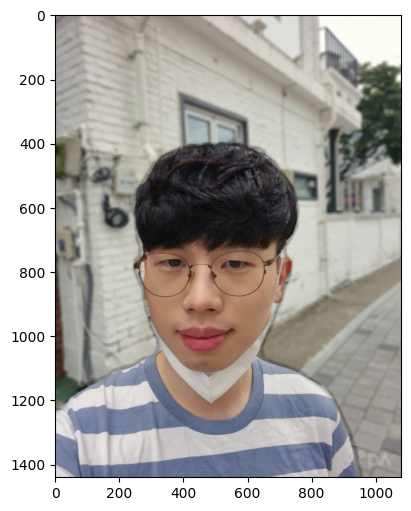

In [ ]:
# 결과 출력
fig = plt.figure(figsize=(16, 6))
plt.imshow(cv2.cvtColor(img_concat.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 마스크 경계의 Feathering을 위해 더 작은 커널로 가우시안 블러 적용
small_blur = cv2.GaussianBlur(img_mask_up, (5, 5), 0)
alpha_mask = small_blur.astype(float) / 255.0
alpha_mask = np.stack([alpha_mask] * 3, axis=-1)

# 경계 부분에서 원본 이미지와 블러 처리된 배경을 부드럽게 전환
img_concat = cv2.addWeighted(img_orig, 0.6, img_bg_blur, 0.4, 0)
img_concat = img_concat * alpha_mask + img_bg_blur * (1 - alpha_mask)


In [ ]:
# 강한 가우시안 블러를 적용하여 마스크 경계를 더욱 부드럽게 처리
img_mask_up = cv2.GaussianBlur(img_mask_up, (41, 41), 0)

# 다시 Feathering 처리
alpha_mask = img_mask_up.astype(float) / 255.0
alpha_mask = np.stack([alpha_mask] * 3, axis=-1)

# 이미지 합성
img_concat = img_orig * alpha_mask + img_bg_blur * (1 - alpha_mask)


In [ ]:
# 이미지 합성 시 가중치 비율 조정
img_concat = cv2.addWeighted(img_orig, 0.7, img_bg_blur, 0.3, 0)
img_concat = img_concat * alpha_mask + img_bg_blur * (1 - alpha_mask)


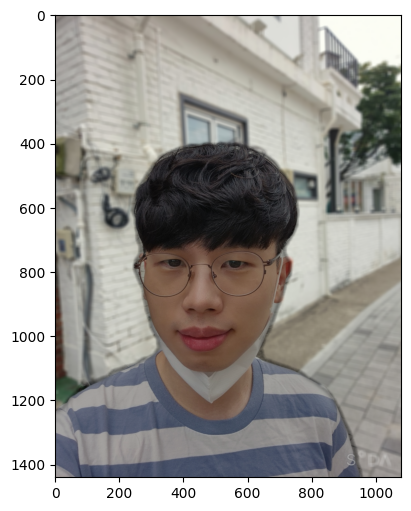

In [ ]:
# 결과 출력
fig = plt.figure(figsize=(16, 6))
plt.imshow(cv2.cvtColor(img_concat.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# 작은 커널로 가우시안 블러 적용
img_mask_up = cv2.GaussianBlur(img_mask_up, (5, 5), 0)  # 커널 크기를 작게 설정

# Feathering을 하지 않거나 최소화
alpha_mask = img_mask_up.astype(float) / 255.0
alpha_mask = np.stack([alpha_mask] * 3, axis=-1)

# 이미지 합성
img_concat = img_orig * alpha_mask + img_bg_blur * (1 - alpha_mask)


In [ ]:
# 경계에 가우시안 블러를 최소한으로 적용
img_mask_up = cv2.GaussianBlur(img_mask_up, (3, 3), 0)  # 매우 작은 블러 적용

# 이미지 합성
img_concat = img_orig * alpha_mask + img_bg_blur * (1 - alpha_mask)


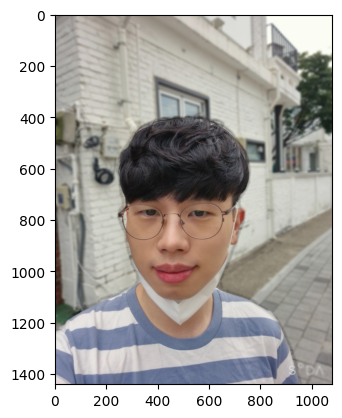

In [ ]:
# 경계 부분만을 위한 추가적인 블렌딩
blurred_edges = cv2.GaussianBlur(img_orig.astype(np.float32), (15, 15), 0)
img_concat = cv2.addWeighted(img_concat.astype(np.float32), 0.7, blurred_edges, 0.3, 0)

# 결과 이미지를 다시 np.uint8로 변환
img_concat = img_concat.astype(np.uint8)

# 결과 출력
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
#회고
김소영 : 처음에 이미지를 좀 더 깨끗하게 분리하기 위해 coco 모델을 써보려고 하다가 버전 문제로 시간을 좀 버리게 되어 아쉽다. 아웃포커싱 과정에서 인물주위에 생기는 선(?)을 제거하려고 시도해보았지만 최종적으로 완벽하게 지워지진 않은것같아 좀 아쉽다

유제민 : CV 모델을 이용해 쉘로우 포커스를 만드는데 많은 시행착오가 있었다. 외부 모델을 불러오는 방법이나 성능적인 부분에서 오류가 많았고 결과가 생각보다 깔끔하게 나오지 않아서 아쉽다.